## Easy 21
### Imports

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Environment

In [11]:
ACTIONS = {'HIT': 0, 'STICK': 1}

class GameState:
    def __init__(self, dealer, player, done):
        self.dealer = dealer
        self.player = player
        self.done = done

def sample_card():
    value = random.randrange(1, 11)
    factor = 1 if random.random() < 0.7 else -1
    return value * factor

def is_busted(cards):
    return cards < 1 or cards > 21

def final_reward(state):
    if state.dealer == state.player:
        return 0
    elif state.dealer < state.player:
        return 1
    else:
        return -1

def reward(state):
    if is_busted(state.dealer):
        return 1
    elif is_busted(state.player):
        return -1
    else:
        if state.done:
            return final_reward(state)
        else:
            return 0
        
def next_state(state, action):
    if state.done:
        return state
    else:
        if action == ACTIONS['HIT']:
            player =  state.player + sample_card()
            return GameState(state.dealer, player, is_busted(player))
        elif action == ACTIONS['STICK']:
            temp = state
            while(not temp.done and temp.dealer < 17):
                dealer = temp.dealer + sample_card()
                temp = GameState(dealer, state.player, is_busted(dealer))
            return GameState(temp.dealer, state.player, True)
        else:
            return state

def initial_state():
    return GameState(random.randrange(1, 11), random.randrange(1, 11), False)
        
def step(state, action):
    state = next_state(state, action)
    return (state, reward(state))

### Monte Carlo Control

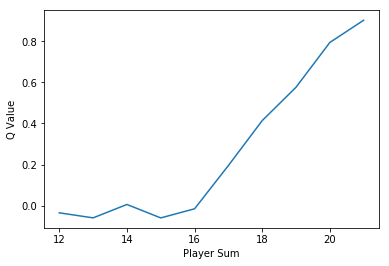

In [46]:
n_0 = 100
n_t = np.zeros((10,21))
n_values = np.zeros((10,21,2))
q_values = np.zeros((10,21,2))

def sample_episode():
    state = initial_state()
    episode = []
    while not state.done:
        epsilon = n_0 / (n_0 + n_t[(state.dealer-1, state.player-1)])
        action = e_greedy(epsilon, state)
        next_state, reward = step(state, action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def e_greedy(epsilon, state):
    max_action = np.argmax(q_values[(state.dealer-1, state.player-1)])
    random_action = random.randrange(2)
    return max_action if random.random() > epsilon else random_action

def update_values(episode):
    g = sum([step[2] for step in episode])
    for (s,a,r) in episode:
        n_t[(s.dealer-1, s.player-1)] += 1
        n_values[(s.dealer-1, s.player-1, a)] += 1
        q_values[(s.dealer-1, s.player-1, a)] += (1 / n_values[(s.dealer-1, s.player-1, a)]) * (g - q_values[(s.dealer-1, s.player-1, a)])
        g -= r
        
def monte_carlo_control(n_iterations):
    for i in range(n_iterations):
        episode = sample_episode()
        update_values(episode)

monte_carlo_control(100000)
plt.plot(np.arange(12,22), np.amax(np.average(q_values[:,11:,:], axis=0), axis=1))
plt.xlabel('Player Sum')
plt.ylabel('Q Value')
plt.show()

## Test

In [47]:
def greedy(state):
    return np.argmax(q_values[(state.dealer-1, state.player-1)])

def play(n_rounds):
    rewards = []
    for _ in range(n_rounds):
        state = initial_state()
        while not state.done:
            action = greedy(state)
            state = next_state(state, action)
        rewards.append(final_reward(state))
    
    wins = 0
    draws = 0
    loss = 0
    for reward in rewards:
        if reward == 1:
            wins += 1
        elif reward == -1:
            loss += 1
        else:
            draws += 1
            
    total_reward = sum(rewards)
    win_rate = round(wins / n_rounds * 100, 2)
    draw_rate = round(draws / n_rounds * 100, 2)
    loss_rate = round(loss / n_rounds * 100, 2)
    
    print(f"Played {n_rounds} rounds")
    print(f"Total reward: {total_reward}")
    print(f"Wins {win_rate}%, draws {draw_rate}%, loss {loss_rate}%")
    
play(5000)

Played 5000 rounds
Total reward: -1651
Wins 33.38%, draws 0.22%, loss 66.4%
